In [60]:
#This model runs the steady-state simulation of a Plug flow reactor for the oxidation of exhaust gas
#emissions (CH4, CO, C2H6, C2H4, H2) over a Pt(111) surface. 
# Refer to the following preprint for details on the setup 10.26434/chemrxiv-2022-r5wn0-v2 

import csv
import cantera as ct
import numpy as np

#######################################################################
# Input Parameters
#######################################################################

#enter the temperature in °C
tc=750
t = tc + 273.15  # convert to Kelvin

#parameters for the PFR model
length = 5e-2  # Length of the monolith m
N_Channel=195  # Number of channels of the monolith
radius=6.31e-4 # radius of the monolith m
GHSV = 30000/3600 # GHSV h^-1
V_flow=12.7/60/1000 #Volumetric flow rate
cross_area=np.pi/4*(radius)**2
area=2*np.pi*(radius)*length
pressure=1e5 # ambient pressure 
vol=length*cross_area
sccm=V_flow/N_Channel
total_cat_area = 0.527 #catalyst surface area measured with CO chemisorption
fcatgeo=total_cat_area/N_Channel/area
cat_area_per_channel=fcatgeo*area/vol

#input file containing the surface reaction mechanism
cti_file = 'chem.cti'
    
gas = ct.Solution(cti_file, 'gas')
gas.TPX = t, pressure, 'N2:73.7445, CH4(1):0.3, O2(6):1.206, CO2(2):12, H2O(3):12, H2(4):0.167, CO(5):0.5, C2H4(7):0.0325, C2H6(8):0.05'

# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = t, pressure
surf.coverages = {'Pt(9)':1}

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 101
dt = 1.0
#Arrays to store the results
gas_frac=np.zeros((NReactors,gas.n_species))
surf_cov=np.zeros((NReactors,surf.n_species))
dist=np.zeros(NReactors)
        
rlen = length/(NReactors-1)
rvol = vol/(NReactors-1)

## catalyst area in one reactor
cat_area = cat_area_per_channel*rvol
mass_flow_rate =  sccm* gas.mean_molecular_weight*pressure/ct.gas_constant/273.15

TDY = gas.TDY
cov = surf.coverages
gas.TDY = TDY
r = ct.IdealGasReactor(gas, energy='off')
r.volume = rvol
upstream = ct.Reservoir(gas, name='upstream')
downstream = ct.Reservoir(gas, name='downstream')

rsurf = ct.ReactorSurface(surf, r, A=cat_area)
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
v = ct.PressureController(r, downstream, master=m, K=1e-9)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 10000

## set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-12
sim.atol = 1.0e-26

#The PFR is set up as a chain of CSTRs
for n in range(NReactors):
            # Set the state of the reservoir to match that of the previous reactor
            gas.TDY = r.thermo.TDY
            upstream.syncState()
            sim.reinitialize()
            sim.advance_to_steady_state(max_steps=1e6)
            dist[n] = n * rlen * 1.0e3   # distance in mm 
            gas_frac[n,:]=gas.X
            surf_cov[n,:]=surf.X 
            

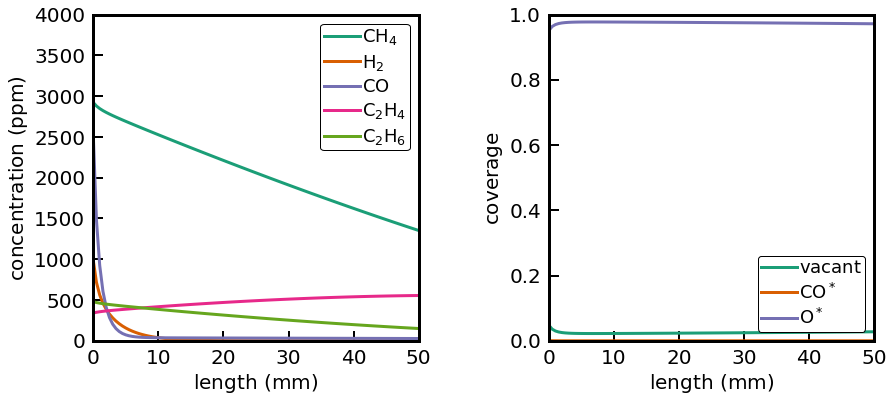

In [62]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

#Makes the diagrams look nice and shiny
plt.rcParams['figure.figsize']=(14,6)
plt.rcParams['axes.linewidth'] = 3
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.major.width']=2
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.major.width']=2
plt.rcParams['legend.edgecolor']='k'
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['legend.handletextpad']=0.1
plt.rcParams['legend.columnspacing']=0.1
plt.rcParams['legend.labelspacing']=0.3
plt.rcParams['legend.borderpad']=0.2
plt.rcParams['legend.title_fontsize'] = 14

colormap=plt.cm.Dark2
colors = [colormap(i) for i in np.linspace(0, 1, 8)]

gs=gridspec.GridSpec(nrows=1, ncols=2)
gs.update(wspace=0.4, hspace=0.4)

ax0=plt.subplot(gs[0,0])
ax1=plt.subplot(gs[0,1])

ax0.plot(dist, gas_frac[:,4]*1e6,  color=colors[0], marker='None', linestyle='solid',linewidth=3, label='$\mathrm{CH_4}$')
ax0.plot(dist, gas_frac[:,7]*1e6,  color=colors[1], marker='None', linestyle='solid',linewidth=3, label='$\mathrm{H_2}$')
ax0.plot(dist, gas_frac[:,8]*1e6,  color=colors[2], marker='None', linestyle='solid',linewidth=3, label='$\mathrm{CO}$')
ax0.plot(dist, gas_frac[:,10]*1e6,  color=colors[3], marker='None', linestyle='solid',linewidth=3, label='$\mathrm{C_2H_4}$')
ax0.plot(dist, gas_frac[:,11]*1e6,  color=colors[4], marker='None', linestyle='solid',linewidth=3, label='$\mathrm{C_2H_6}$')

ax0.set_xlabel('$\mathrm{length\ (mm)}$')
ax0.set_xlim([0, 50])
ax0.set_ylim([0, 4000])
ax0.set_ylabel('$\mathrm{concentration\ (ppm)}$')
ax0.legend()

ax1.plot(dist, surf_cov[:,0],  color=colors[0], marker='None', linestyle='solid',linewidth=3, label='$\mathrm{vacant}$')
ax1.plot(dist, surf_cov[:,1],  color=colors[1], marker='None', linestyle='solid',linewidth=3, label='$\mathrm{CO^*}$')
ax1.plot(dist, surf_cov[:,2],  color=colors[2], marker='None', linestyle='solid',linewidth=3, label='$\mathrm{O^*}$')
ax1.set_xlabel('$\mathrm{length\ (mm)}$')
ax1.set_xlim([0, 50])
ax1.set_ylim([0, 1])
ax1.set_ylabel('$\mathrm{coverage}$')
ax1.legend()